## Path Planning

We move the robot in the direction of the point that is furthest away. Since our simulated Lidar has a range larger than the maximum distance for this race track we do not have to deal with None values.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from LidarSim.lidar_sim import LidarSimulator

In [14]:
lidar = LidarSimulator("racetrack.stl")

In [15]:
def get_longest_distance(scan):
    view_angle = 120  # degrees
    sample_each_side = int(len(scan) / 360 * view_angle / 2)
    max_distance = 0
    max_index = 0
    for i in range(sample_each_side):
        if scan[i] is None:
            continue
        if scan[i] > max_distance:
            max_distance = scan[i]
            max_index = i
        if scan[-i] is None:
            continue
        if scan[-i] > max_distance:
            max_distance = scan[-i]
            max_index = -i

    return max_index

In [16]:
def calc_cmd_vel(pose, lidar):
    vel_max = 1.0 # m/sec
    lidar_scan = lidar.lidar_scan(pose[0] * 100, pose[1] * 100, pose[2])
    target_index = get_longest_distance(lidar_scan)
    # angel in map coordinate system\
    angular_z = pose[2] + np.radians(lidar.resolution) * target_index
    linear_x = vel_max
    return {"linear_x": linear_x, "angular_z": angular_z}

In [17]:
def get_odom(cmd_vel, pose, dt):
    x = pose[0] + cmd_vel["linear_x"] * np.cos(cmd_vel["angular_z"]) * dt
    y = pose[1] + cmd_vel["linear_x"] * np.sin(cmd_vel["angular_z"]) * dt
    return [x, y, cmd_vel["angular_z"]]

In [18]:
way_points = []
dt = 0.5
pose = [9, 0.5, np.pi]
way_points.append(pose)
for i in range(50):
    pose = get_odom(calc_cmd_vel(pose, lidar), pose, dt)
    way_points.append(pose)

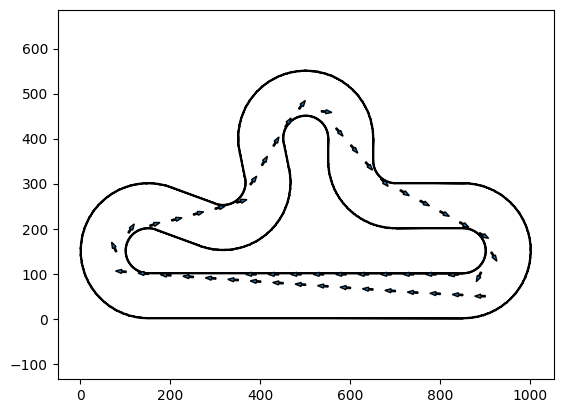

In [19]:
path = np.array(way_points)
triangles = lidar.get_map_triangles()

fig, ax = plt.subplots(1, 1)
ax.axis('equal')
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)
for i in range(path.shape[0]):
    ax.arrow(path[i, 0] * 100, path[i, 1] * 100, 10 * np.cos(path[i, 2]), 10 * np.sin(path[i, 2]), width=3.0)

### Debug

In [20]:
pose = way_points[18]

In [21]:
point = [pose[0] * 100, pose[1] * 100]
yaw = pose[2]
plot_scan = lidar.get_lidar_points(point[0], point[1], yaw)
triangles = lidar.get_env_triangles(point[0], point[1], yaw)

In [22]:
lidar_scan = lidar.lidar_scan(pose[0] * 100, pose[1] * 100, pose[2])
target_index = get_longest_distance(lidar_scan)
target_angle = np.radians(lidar.resolution) * target_index
target_point = [np.radians(lidar.resolution) * target_index, lidar_scan[target_index]]

In [23]:
target_line = np.stack(([0., 0.], target_point))

Text(0.5, 1.0, 'Lidar Scann')

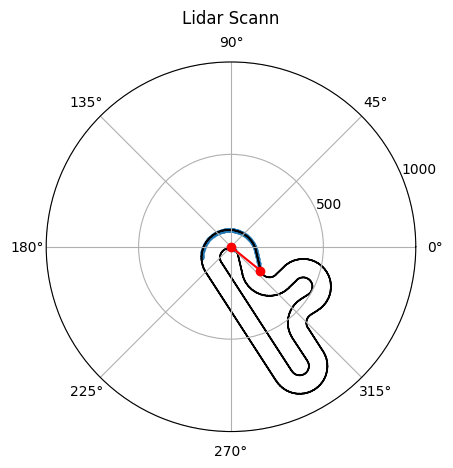

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(target_line[:, 0], target_line[:, 1], 'ro-')
ax.scatter(plot_scan[:, 0], plot_scan[:, 1], s=3.0)
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.grid(True)

ax.set_title("Lidar Scann", va='bottom')